## Regresion Lineal para la reconstruccion de ventas en periodos negados

In [ ]:
import cx_Oracle as oc
import pandas as pd
import numpy as np

In [ ]:
con=oc.connect('SYSTEM/admin@localhost')

Consulta el modelo y talla negada en la tienda

In [ ]:
sql=pd.read_sql_query('''
select TI_CVE_N,
       ULT_SUST_DEF_N,
       TALLA_INI_MIN,
       TALLA_FIN_MAX,
       TA_CVE_N,
       FECHA,
       EXISTENCIA,
       VENTA
from ventas
where ult_sust_def_n=1560 and 
ta_cve_n=26
''',con)

In [ ]:
df=pd.DataFrame(sql)

Establece la fecha como indice

In [ ]:
df = df.set_index('FECHA')
df.head(10)

,TI_CVE_N,ULT_SUST_DEF_N,TALLA_INI_MIN,TALLA_FIN_MAX,TA_CVE_N,EXISTENCIA,VENTA
FECHA,,,,,,,
2019-03-01,1,1560,25.0,32.0,26.0,19,0
2019-03-02,1,1560,25.0,32.0,26.0,19,0
2019-03-03,1,1560,25.0,32.0,26.0,19,1
2019-03-04,1,1560,25.0,32.0,26.0,18,1
2019-03-05,1,1560,25.0,32.0,26.0,17,3
2019-03-06,1,1560,25.0,32.0,26.0,14,2
2019-03-07,1,1560,25.0,32.0,26.0,12,1
2019-03-08,1,1560,25.0,32.0,26.0,11,1
2019-03-09,1,1560,25.0,32.0,26.0,10,1


Se muestra el comportamiento de la venta vs existencia

In [ ]:
import seaborn as sns

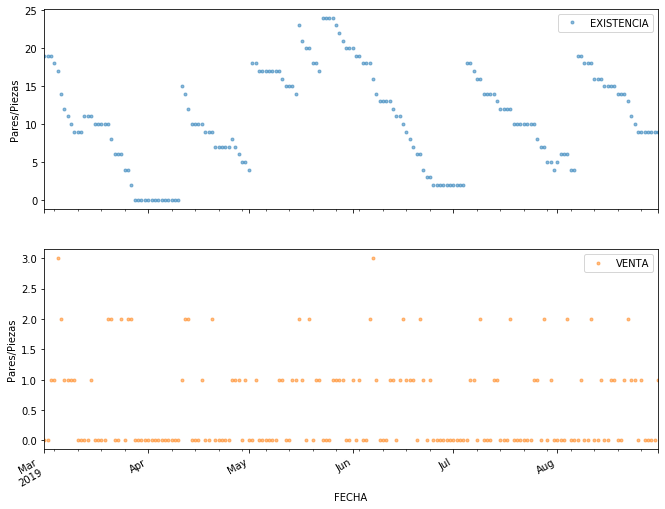

In [ ]:
cols_plot = ['EXISTENCIA', 'VENTA']
axes = df[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Pares/Piezas')

Se obtiene el dia de la semana para hacer la regresion lineal con ventas del mismo dia

In [ ]:
# Add columns with year, month, and weekday name
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Weekday Name'] = df.index.weekday_name
df['Day Number'] = df.index.dayofyear

negados=df[df["EXISTENCIA"]==0]
negados.head(14)

,TI_CVE_N,ULT_SUST_DEF_N,TALLA_INI_MIN,TALLA_FIN_MAX,TA_CVE_N,EXISTENCIA,VENTA,Year,Month,Weekday Name,Day Number
FECHA,,,,,,,,,,,
2019-03-28,1,1560,25.0,32.0,26.0,0,0,2019,3,Thursday,87
2019-03-29,1,1560,25.0,32.0,26.0,0,0,2019,3,Friday,88
2019-03-30,1,1560,25.0,32.0,26.0,0,0,2019,3,Saturday,89
2019-03-31,1,1560,25.0,32.0,26.0,0,0,2019,3,Sunday,90
2019-04-01,1,1560,25.0,32.0,26.0,0,0,2019,4,Monday,91
2019-04-02,1,1560,25.0,32.0,26.0,0,0,2019,4,Tuesday,92
2019-04-03,1,1560,25.0,32.0,26.0,0,0,2019,4,Wednesday,93
2019-04-04,1,1560,25.0,32.0,26.0,0,0,2019,4,Thursday,94
2019-04-05,1,1560,25.0,32.0,26.0,0,0,2019,4,Friday,95


Se localiza el periodo negado

In [ ]:
periodo=df.loc['2019-03-01':'2019-04-30']

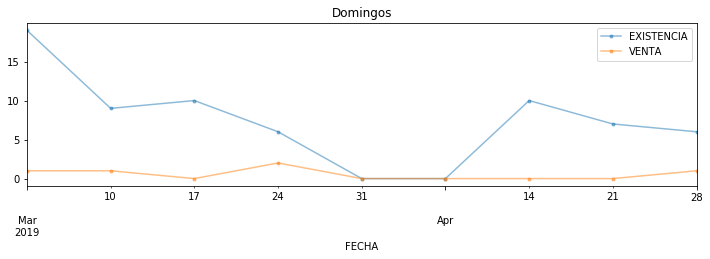

In [ ]:
sunday=periodo[periodo['Weekday Name']=='Sunday']

axes = sunday[['EXISTENCIA', 'VENTA']].plot(marker='.', alpha=0.5, linestyle='-', figsize=(12, 3), title='Domingos')

Se toman los dias con existencia para hacer la regresion lineal

In [ ]:
domingos=sunday[sunday["EXISTENCIA"]>0]
X = domingos["Day Number"].to_numpy().reshape(-1, 1)
Y = domingos["VENTA"].to_numpy().reshape(-1, 1)
print(X)
print(Y)

[[ 62]
 [ 69]
 [ 76]
 [ 83]
 [104]
 [111]
 [118]]
[[1]
 [1]
 [0]
 [2]
 [0]
 [0]
 [1]]


Se calcula la Regresion Lineal

In [ ]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X, Y)
print(lm.intercept_,lm.coef_,lm.score(X, Y))

[1.64008322] [[-0.01040222]] 0.09101941747572817


Se estiman las ventas de todos los dias incluidos los dias negados

In [ ]:
x = sunday["Day Number"].to_numpy().reshape(-1, 1)
y = lm.predict(x)
sunday["vta_estimada"]=y

C:\Users\jcjim\Anaconda3\envs\IA\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Se grafican las ventas estimadas con la regresion lineal

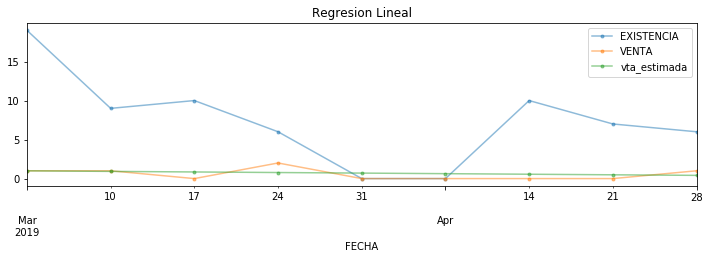

In [ ]:
sunday[['EXISTENCIA', 'VENTA','vta_estimada']].plot(marker='.', alpha=0.5, linestyle='-', figsize=(12, 3), title='Regresion Lineal')

In [ ]:
sunday[sunday["EXISTENCIA"]==0]

,TI_CVE_N,ULT_SUST_DEF_N,TALLA_INI_MIN,TALLA_FIN_MAX,TA_CVE_N,EXISTENCIA,VENTA,Year,Month,Weekday Name,Day Number,vta_estimada
FECHA,,,,,,,,,,,,
2019-03-31,1,1560,25.0,32.0,26.0,0,0,2019,3,Sunday,90,0.703883
2019-04-07,1,1560,25.0,32.0,26.0,0,0,2019,4,Sunday,97,0.631068


#Regresion Lineal Multiple

Para hacer **la reconstrucción del negado** se propone lo siguiente:

* Este método aplica a modelos con una venta alta por talla-tienda.
* *Tomar en cuenta los mismos días* donde se tuvo existencia en esa talla, es decir, si se quiere reconstruir un día **domingo** se deben tomar los **domingos anteriores y siguientes** de día que se va a reconstruir
* *Tomar las tallas cercanas* para considerar la curva de venta, es decir, si se quiere reconstruir la talla 26 se debe tomar la talla 25 y 27 para tomar en cuenta su proporción de venta cuando tuvo existencia.
* *Tomar las tiendas que son de la misma región* para **considerar la participación de venta de ese mismo modelo y tallas entre las tiendas de la misma región**.

In [28]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import statsmodels.api as sm

In [52]:
df=pd.read_excel('existenciaventa.xls')
df2=df[df['EXISTENCIA']>0]
df2.head()

,TI_CVE_N,ID_ART,TA_CVE_N,FECHA,DIA_DEL_ANIO,EXISTENCIA,VENTA
0,1,1560,25,2019-03-17,76,7,0
1,1,1560,25,2019-03-24,83,6,1
2,1,1560,25,2019-03-31,90,3,0
3,1,1560,25,2019-04-07,97,3,0
4,1,1560,25,2019-04-14,104,8,0


In [53]:
df[df['EXISTENCIA']==0]

,TI_CVE_N,ID_ART,TA_CVE_N,FECHA,DIA_DEL_ANIO,EXISTENCIA,VENTA
8,1,1560,26,2019-03-31,90,0,0
9,1,1560,26,2019-04-07,97,0,0
14,1,1560,27,2019-03-31,90,0,0
21,4,1560,25,2019-04-07,97,0,0
33,4,1560,27,2019-04-07,97,0,0
51,5,1560,27,2019-04-07,97,0,0


In [54]:
X = df2[['DIA_DEL_ANIO','TI_CVE_N','TA_CVE_N']] # here we have 3 variables for multiple regression.
y = df2['VENTA']

In [55]:
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 -4.5547778704132975
Coefficients: 
 [-0.00687229  0.01126854  0.21635316]


In [64]:
def reconstruye(d,tienda,talla):
  return np.asscalar(regr.predict([[d,tienda,talla]]))

negado = df[df['EXISTENCIA']==0]
negado['VENTA']=negado.apply(lambda row: reconstruye(row['DIA_DEL_ANIO'],
                                                     row['TI_CVE_N'],
                                                     row['TA_CVE_N']),axis=1)
negado

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: 

,TI_CVE_N,ID_ART,TA_CVE_N,FECHA,DIA_DEL_ANIO,EXISTENCIA,VENTA
8,1,1560,26,2019-03-31,90,0,0.463167
9,1,1560,26,2019-04-07,97,0,0.415061
14,1,1560,27,2019-03-31,90,0,0.679520
21,4,1560,25,2019-04-07,97,0,0.232513
33,4,1560,27,2019-04-07,97,0,0.665219
51,5,1560,27,2019-04-07,97,0,0.676488


In [78]:
#df1.loc[df1.index.isin(df2.index), :] = df2.city_in_mail
df.loc[df.index.isin(negado.index),'VENTA']=negado.VENTA
df[df['EXISTENCIA']==0]

,TI_CVE_N,ID_ART,TA_CVE_N,FECHA,DIA_DEL_ANIO,EXISTENCIA,VENTA
8,1,1560,26,2019-03-31,90,0,0.463167
9,1,1560,26,2019-04-07,97,0,0.415061
14,1,1560,27,2019-03-31,90,0,0.679520
21,4,1560,25,2019-04-07,97,0,0.232513
33,4,1560,27,2019-04-07,97,0,0.665219
51,5,1560,27,2019-04-07,97,0,0.676488


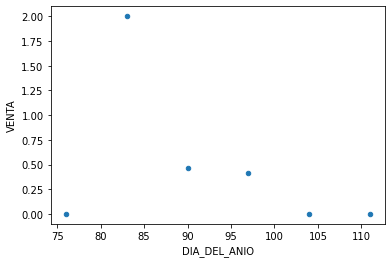

In [93]:
df.query('TI_CVE_N==1 and TA_CVE_N==26').plot(kind='scatter',x='DIA_DEL_ANIO',y='VENTA')

TI_CVE_N  TA_CVE_N
1         25          AxesSubplot(0.125,0.125;0.775x0.755)
          26          AxesSubplot(0.125,0.125;0.775x0.755)
          27          AxesSubplot(0.125,0.125;0.775x0.755)
4         25          AxesSubplot(0.125,0.125;0.775x0.755)
          26          AxesSubplot(0.125,0.125;0.775x0.755)
          27          AxesSubplot(0.125,0.125;0.775x0.755)
5         25          AxesSubplot(0.125,0.125;0.775x0.755)
          26          AxesSubplot(0.125,0.125;0.775x0.755)
          27          AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

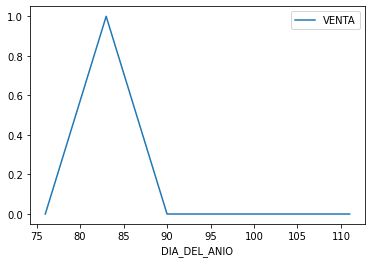

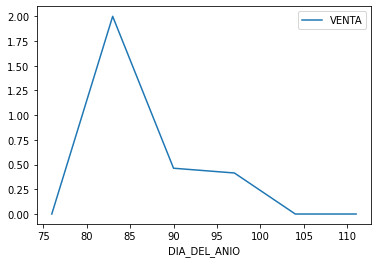

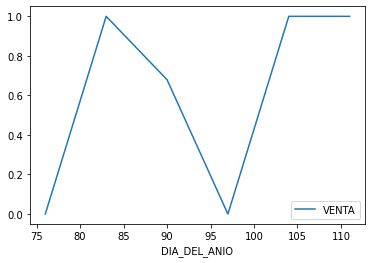

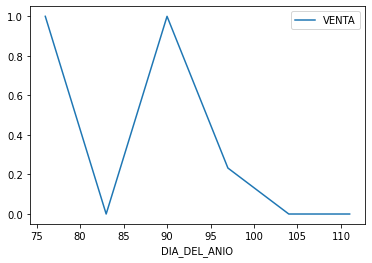

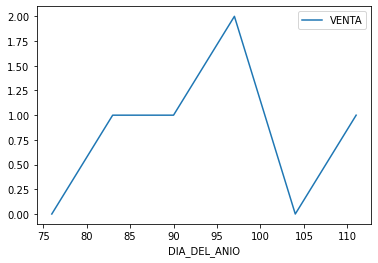

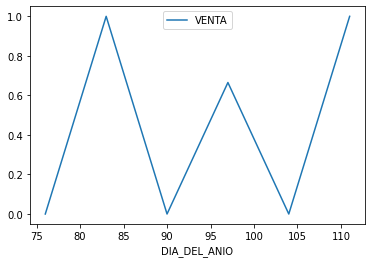

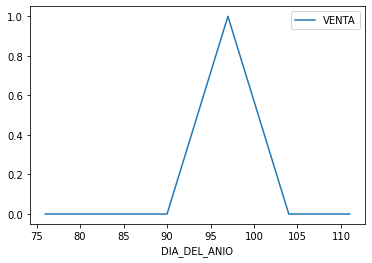

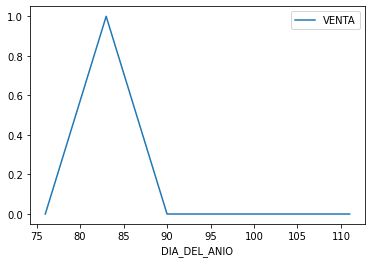

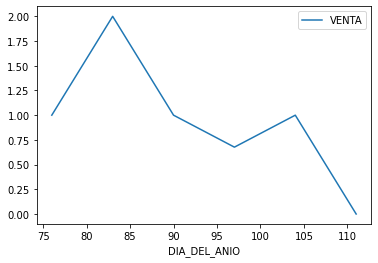

In [102]:
df3=df.groupby(['TI_CVE_N','TA_CVE_N'])
df3.plot(x='DIA_DEL_ANIO',y='VENTA',subplots=False)

In [19]:
# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                  VENTA   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     1.719
Date:                Fri, 04 Dec 2020   Prob (F-statistic):              0.177
Time:                        16:31:55   Log-Likelihood:                -41.797
No. Observations:                  48   AIC:                             91.59
Df Residuals:                      44   BIC:                             99.08
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -4.5548      2.854     -1.596   